# League of Legends: Who wins?
## This notebook is designed to see whether we can determine which team will go on to win a LoL match, based on the first 15 minutes of play

### The data were made available by Ben Fattori on [Kaggle](https://www.kaggle.com/benfattori/league-of-legends-diamond-games-first-15-minutes) and this analysis is heavily inspired by Ken Jee's analysis of the Titanic dataset (on [Kaggle](https://www.kaggle.com/kenjee/titanic-project-example) and [YouTube](https://www.youtube.com/watch?v=I3FBJdiExcg&t=0s))


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
lol_matches = pd.read_csv('MatchTimelinesFirst15.csv', index_col=0)
lol_matches.head()

,matchId,blue_win,blueGold,blueMinionsKilled,blueJungleMinionsKilled,blueAvgLevel,redGold,redMinionsKilled,redJungleMinionsKilled,redAvgLevel,blueChampKills,blueHeraldKills,blueDragonKills,blueTowersDestroyed,redChampKills,redHeraldKills,redDragonKills,redTowersDestroyed
0,3.493251e+09,0,24575.0,349.0,89.0,8.6,25856.0,346.0,80.0,9.2,6.0,1.0,0.0,1.0,12.0,2.0,0.0,1.0
1,3.464936e+09,0,27210.0,290.0,36.0,9.0,28765.0,294.0,92.0,9.4,20.0,0.0,0.0,0.0,19.0,2.0,0.0,0.0
2,3.428426e+09,1,32048.0,346.0,92.0,9.4,25305.0,293.0,84.0,9.4,17.0,3.0,0.0,0.0,11.0,0.0,0.0,4.0
3,3.428347e+09,0,20261.0,223.0,60.0,8.2,30429.0,356.0,107.0,9.4,7.0,0.0,0.0,3.0,16.0,3.0,0.0,0.0
4,3.428351e+09,1,30217.0,376.0,110.0,9.8,23889.0,334.0,60.0,8.8,16.0,3.0,0.0,0.0,8.0,0.0,0.0,2.0


First we need to understand the nature of the data using .info() to get non-null counts and data types, and .describe() to get counts, mix-max, and percentiles.
We can then use histograms and boxplots for the numerical (continuous) data, and get the value counts of the categoriacal (discrete) data.
Finally, we can also look at the Pearson correlations between the features, and explore interesting themes.

Then we can see if any feature engineering can be performed, and how the features should be preprocessed, e.g. by scaling or normalising.

A baseline model can be generated and then we can perform a model comparison with CV.

In [3]:
lol_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48651 entries, 0 to 48650
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   matchId                  48651 non-null  float64
 1   blue_win                 48651 non-null  int64  
 2   blueGold                 48651 non-null  float64
 3   blueMinionsKilled        48651 non-null  float64
 4   blueJungleMinionsKilled  48651 non-null  float64
 5   blueAvgLevel             48651 non-null  float64
 6   redGold                  48651 non-null  float64
 7   redMinionsKilled         48651 non-null  float64
 8   redJungleMinionsKilled   48651 non-null  float64
 9   redAvgLevel              48651 non-null  float64
 10  blueChampKills           48651 non-null  float64
 11  blueHeraldKills          48651 non-null  float64
 12  blueDragonKills          48651 non-null  float64
 13  blueTowersDestroyed      48651 non-null  float64
 14  redChampKills         

In [4]:
lol_matches.isna().sum()

matchId                    0
blue_win                   0
blueGold                   0
blueMinionsKilled          0
blueJungleMinionsKilled    0
blueAvgLevel               0
redGold                    0
redMinionsKilled           0
redJungleMinionsKilled     0
redAvgLevel                0
blueChampKills             0
blueHeraldKills            0
blueDragonKills            0
blueTowersDestroyed        0
redChampKills              0
redHeraldKills             0
redDragonKills             0
redTowersDestroyed         0
dtype: int64

In [5]:
lol_matches.describe()

,matchId,blue_win,blueGold,blueMinionsKilled,blueJungleMinionsKilled,blueAvgLevel,redGold,redMinionsKilled,redJungleMinionsKilled,redAvgLevel,blueChampKills,blueHeraldKills,blueDragonKills,blueTowersDestroyed,redChampKills,redHeraldKills,redDragonKills,redTowersDestroyed
count,4.865100e+04,48651.000000,48651.000000,48651.000000,48651.000000,48651.000000,48651.000000,48651.000000,48651.000000,48651.000000,48651.000000,48651.000000,48651.0,48651.000000,48651.000000,48651.000000,48651.0,48651.000000
mean,3.486083e+09,0.505416,26349.160572,335.859140,83.136585,9.172251,26203.028591,336.693984,84.692997,9.174759,11.013155,1.316355,0.0,0.794084,10.747693,1.287188,0.0,0.891657
std,2.812307e+07,0.499976,2777.299868,32.673096,14.794947,0.413735,2754.709425,33.278962,14.902326,0.421396,4.532898,0.956784,0.0,1.054556,4.453358,0.952450,0.0,1.111205
min,2.544365e+09,0.000000,15930.000000,120.000000,0.000000,5.400000,11133.000000,14.000000,1.000000,2.400000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
25%,3.475554e+09,0.000000,24401.500000,315.000000,73.000000,9.000000,24301.000000,316.000000,75.000000,9.000000,8.000000,1.000000,0.0,0.000000,8.000000,1.000000,0.0,0.000000
50%,3.494380e+09,1.000000,26167.000000,337.000000,83.000000,9.200000,26029.000000,338.000000,84.000000,9.200000,11.000000,1.000000,0.0,1.000000,10.000000,1.000000,0.0,1.000000
75%,3.506802e+09,1.000000,28126.000000,358.000000,92.000000,9.400000,27940.000000,359.000000,94.000000,9.400000,14.000000,2.000000,0.0,1.000000,14.000000,2.000000,0.0,1.000000
max,3.513125e+09,1.000000,39769.000000,455.000000,164.000000,10.800000,39999.000000,457.000000,160.000000,10.600000,50.000000,4.000000,0.0,11.000000,43.000000,4.000000,0.0,10.000000


There are no Dragon kills for either the red or blue team. We can assume that these data were collected after V6.9 replaced the 'Dragon' mob with elemental drakes - https://leagueoflegends.fandom.com/wiki/V6.9
We can therefore remove these columns.

In [6]:
lol_matches = lol_matches.drop(['matchId','redDragonKills','blueDragonKills'],axis=1)
lol_matches.head()

,blue_win,blueGold,blueMinionsKilled,blueJungleMinionsKilled,blueAvgLevel,redGold,redMinionsKilled,redJungleMinionsKilled,redAvgLevel,blueChampKills,blueHeraldKills,blueTowersDestroyed,redChampKills,redHeraldKills,redTowersDestroyed
0,0,24575.0,349.0,89.0,8.6,25856.0,346.0,80.0,9.2,6.0,1.0,1.0,12.0,2.0,1.0
1,0,27210.0,290.0,36.0,9.0,28765.0,294.0,92.0,9.4,20.0,0.0,0.0,19.0,2.0,0.0
2,1,32048.0,346.0,92.0,9.4,25305.0,293.0,84.0,9.4,17.0,3.0,0.0,11.0,0.0,4.0
3,0,20261.0,223.0,60.0,8.2,30429.0,356.0,107.0,9.4,7.0,0.0,3.0,16.0,3.0,0.0
4,1,30217.0,376.0,110.0,9.8,23889.0,334.0,60.0,8.8,16.0,3.0,0.0,8.0,0.0,2.0


It looks like the number of Herald kills is discrete between 0 and 4, which is supported by the mechanics of the Herald.  This mob will only spawn twice at most in the first 15 min, and can potentially be summoned up to twice by the team which gets the kills for the spawned mob.

In [7]:
lol_matches['redHeraldKills'].value_counts()

1.0    17935
2.0    13677
0.0    11269
3.0     5746
4.0       24
Name: redHeraldKills, dtype: int64

In [8]:
lol_matches['blueHeraldKills'].value_counts()

1.0    18020
2.0    13684
0.0    10739
3.0     6178
4.0       30
Name: blueHeraldKills, dtype: int64

In [9]:
lol_matches.corr()

,blue_win,blueGold,blueMinionsKilled,blueJungleMinionsKilled,blueAvgLevel,redGold,redMinionsKilled,redJungleMinionsKilled,redAvgLevel,blueChampKills,blueHeraldKills,blueTowersDestroyed,redChampKills,redHeraldKills,redTowersDestroyed
blue_win,1.000000,0.521364,0.284272,0.246505,0.457024,-0.519554,-0.300026,-0.267774,-0.458572,0.424738,0.391925,-0.387619,-0.418306,-0.396969,0.389624
blueGold,0.521364,1.000000,0.346955,0.299570,0.703495,-0.456804,-0.495301,-0.363318,-0.525359,0.865140,0.450115,-0.460574,-0.258176,-0.432055,0.711208
blueMinionsKilled,0.284272,0.346955,1.000000,0.281259,0.561064,-0.486606,0.035158,-0.023374,-0.176940,0.017363,0.196358,-0.422873,-0.515020,-0.185863,0.264474
blueJungleMinionsKilled,0.246505,0.299570,0.281259,1.000000,0.475889,-0.344069,-0.018286,-0.209181,-0.199804,0.069145,0.317968,-0.260696,-0.334563,-0.259751,0.220252
blueAvgLevel,0.457024,0.703495,0.561064,0.475889,1.000000,-0.519865,-0.188483,-0.212622,-0.319492,0.539841,0.351571,-0.512570,-0.445715,-0.347737,0.399790
redGold,-0.519554,-0.456804,-0.486606,-0.344069,-0.519865,1.000000,0.368973,0.319473,0.706237,-0.261095,-0.426647,0.700076,0.865389,0.453199,-0.471831
redMinionsKilled,-0.300026,-0.495301,0.035158,-0.018286,-0.188483,0.368973,1.000000,0.296705,0.572012,-0.519074,-0.196499,0.271587,0.037182,0.217338,-0.441944
redJungleMinionsKilled,-0.267774,-0.363318,-0.023374,-0.209181,-0.212622,0.319473,0.296705,1.000000,0.500910,-0.349442,-0.280140,0.221266,0.085537,0.338895,-0.290675
redAvgLevel,-0.458572,-0.525359,-0.176940,-0.199804,-0.319492,0.706237,0.572012,0.500910,1.000000,-0.450534,-0.347618,0.392062,0.538200,0.364736,-0.527255
blueChampKills,0.424738,0.865140,0.017363,0.069145,0.539841,-0.261095,-0.519074,-0.349442,-0.450534,1.000000,0.334124,-0.312708,-0.058919,-0.351814,0.470470


In [10]:
lol_matches.columns

Index(['blue_win', 'blueGold', 'blueMinionsKilled', 'blueJungleMinionsKilled',
       'blueAvgLevel', 'redGold', 'redMinionsKilled', 'redJungleMinionsKilled',
       'redAvgLevel', 'blueChampKills', 'blueHeraldKills',
       'blueTowersDestroyed', 'redChampKills', 'redHeraldKills',
       'redTowersDestroyed'],
      dtype='object')

In [11]:
cat_col = lol_matches[['blue_win','redHeraldKills','blueHeraldKills']]
num_col = lol_matches[['blueGold', 'blueMinionsKilled', 'blueJungleMinionsKilled',
       'blueAvgLevel', 'redGold', 'redMinionsKilled', 'redJungleMinionsKilled',
       'redAvgLevel', 'blueChampKills', 'blueTowersDestroyed', 'redChampKills',
       'redTowersDestroyed']]
#Take all feature columns
feature_col = lol_matches[['blueGold', 'blueMinionsKilled', 'blueJungleMinionsKilled',
       'blueAvgLevel', 'redGold', 'redMinionsKilled', 'redJungleMinionsKilled',
       'redAvgLevel', 'blueChampKills', 'blueTowersDestroyed', 'redChampKills',
       'redTowersDestroyed','redHeraldKills','blueHeraldKills']]

We can plot histograms for the numeric features

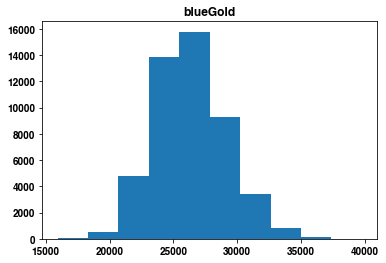

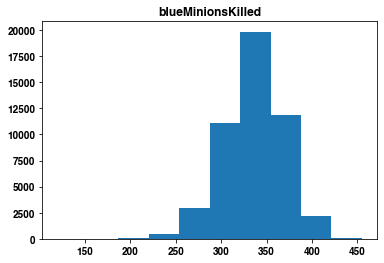

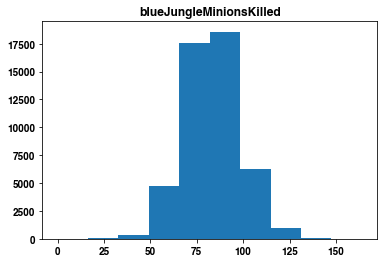

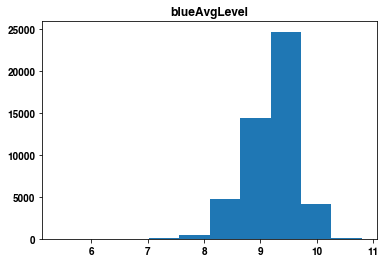

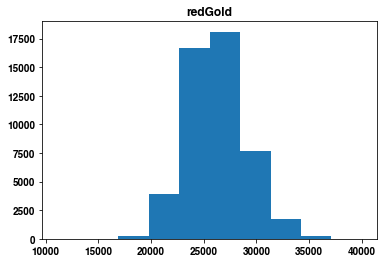

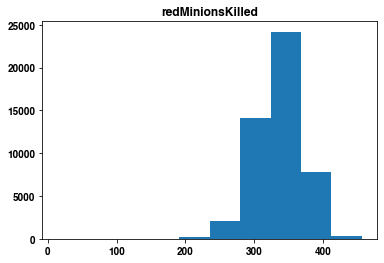

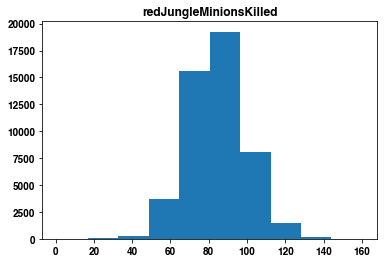

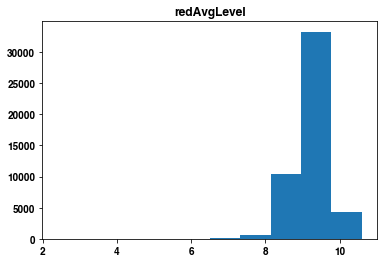

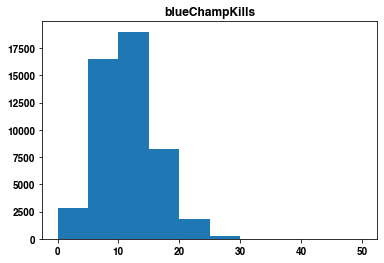

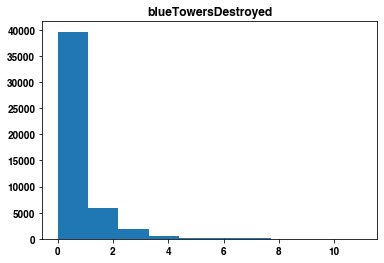

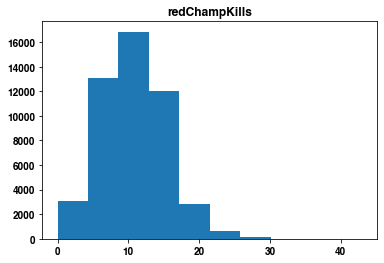

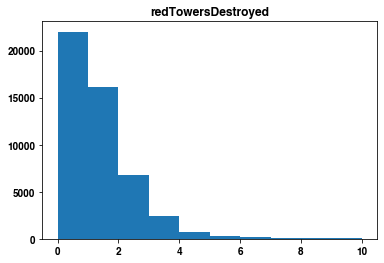

In [12]:
for i in num_col.columns:
    plt.hist(num_col[i])
    plt.title(i)
    plt.show()

All the (approximately) continuous features appear to be normally distributed, with the exception of tower kills

We can also plot the bar charts for the categorial features

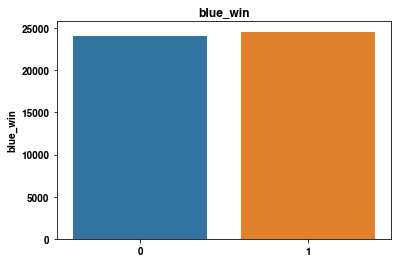

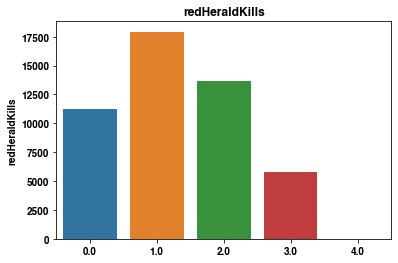

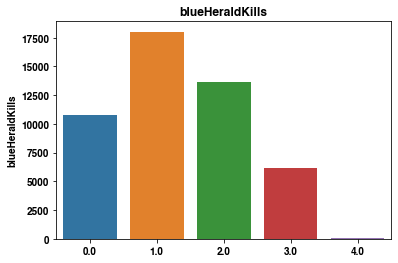

In [15]:
for i in cat_col.columns:
    sns.barplot(x= cat_col[i].value_counts().index,y = cat_col[i].value_counts()).set_title(i)
    plt.show()

Crucially, we see that our dataset is well balanced in terms of which team wins

<AxesSubplot:>

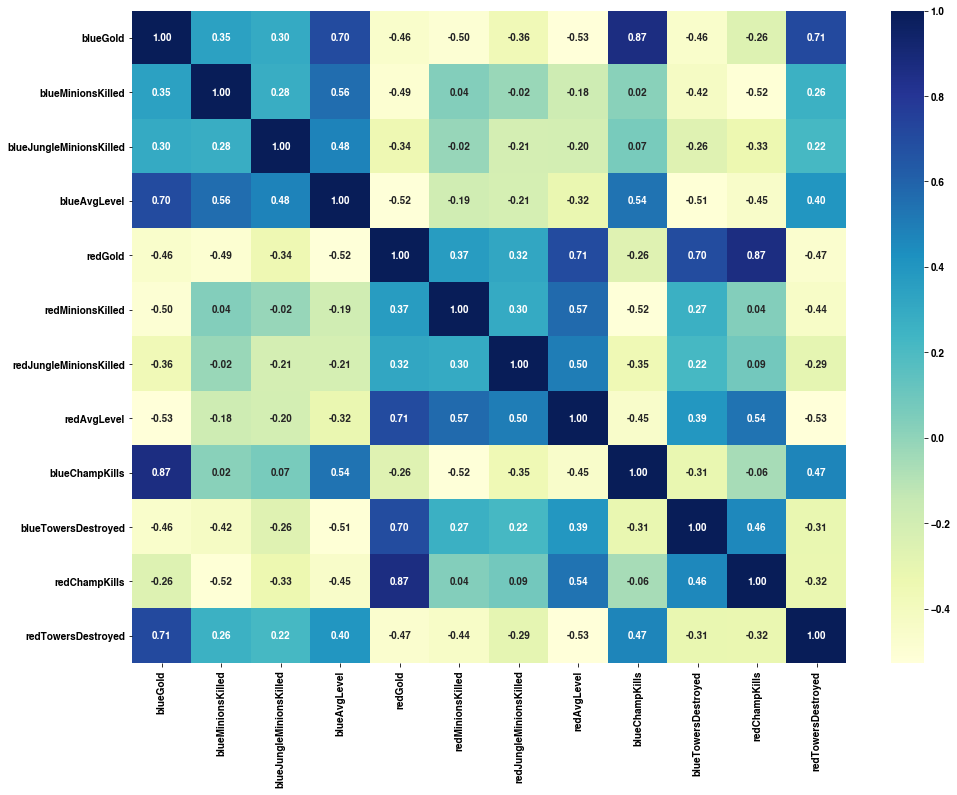

In [85]:
#Plot a heatmap to explore correlations between the numerical feature columns
plt.figure(figsize=(16, 12))
sns.heatmap(num_col.corr(), cmap='YlGnBu', annot=True, fmt='.2f')

In [14]:
# Compare the win rate across various features
pd.pivot_table(lol_matches, index = 'blue_win', values = ['blueGold', 'blueMinionsKilled', 'blueJungleMinionsKilled',
       'blueAvgLevel', 'redGold', 'redMinionsKilled', 'redJungleMinionsKilled',
       'redAvgLevel', 'blueChampKills', 'blueTowersDestroyed', 'redChampKills',
       'redTowersDestroyed'])

,blueAvgLevel,blueChampKills,blueGold,blueJungleMinionsKilled,blueMinionsKilled,blueTowersDestroyed,redAvgLevel,redChampKills,redGold,redJungleMinionsKilled,redMinionsKilled,redTowersDestroyed
blue_win,,,,,,,,,,,,
0,8.981107,9.066910,24885.419957,79.449879,326.470036,1.207298,9.370102,12.630829,27649.821586,88.726872,346.787175,0.453994
1,9.359299,12.917687,27781.529790,86.744276,345.047013,0.389727,8.983602,8.904917,24787.243768,80.745577,326.817113,1.319940


Is there any feature engineering we can do? 
By default, there are only two Herald spwans per game, if no team summons a Herald. The Herald will also despawn at 19:45 min if still alive. We don't have enough information to determine whether two Herald kills implies killing the respawn before 19:45 or is due to summoning the Herald from the drop after the first kill. 

In [104]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [105]:
#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(lol_matches[lol_matches.columns[1:]],lol_matches[lol_matches.columns[0]], test_size=0.33, random_state=42)

In [106]:
#Let us try using a OneHotEncoder on the number of Herald kills, as it is the most categorical feature
enc = OneHotEncoder(handle_unknown='ignore')
herald_kills_train = X_train[['blueHeraldKills','redHeraldKills']]
enc.fit(herald_kills_train)
herald_kills_train_enc = enc.transform(herald_kills_train).toarray()


column_names = enc.get_feature_names(['blueHeraldKills','redHeraldKills'])
herald_kills_train_enc =  pd.DataFrame(herald_kills_train_enc, columns= column_names)
herald_kills_train_enc = herald_kills_train_enc.set_index(X_train.index)
herald_kills_train_enc.head()

,blueHeraldKills_0.0,blueHeraldKills_1.0,blueHeraldKills_2.0,blueHeraldKills_3.0,blueHeraldKills_4.0,redHeraldKills_0.0,redHeraldKills_1.0,redHeraldKills_2.0,redHeraldKills_3.0,redHeraldKills_4.0
17049,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32918,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16522,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8814,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
46530,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [107]:
herald_kills_test = X_test[['blueHeraldKills','redHeraldKills']]

herald_kills_test_enc = enc.transform(herald_kills_test).toarray()

column_names = enc.get_feature_names(['blueHeraldKills','redHeraldKills'])
herald_kills_test_enc =  pd.DataFrame(herald_kills_test_enc, columns= column_names)
herald_kills_test_enc = herald_kills_test_enc.set_index(X_test.index)

In [108]:
#We can also scale our remaining features so that the mean is zero and there is unit variance
#Make sure to only fit the scaler on the train data and simply transform the test data to avoid data leakage 
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_scaled[feature_col.columns]),columns =feature_col.columns)
X_train_scaled = X_train_scaled.set_index(X_train.index)
X_train_scaled.head()

,blueGold,blueMinionsKilled,blueJungleMinionsKilled,blueAvgLevel,redGold,redMinionsKilled,redJungleMinionsKilled,redAvgLevel,blueChampKills,blueTowersDestroyed,redChampKills,redTowersDestroyed,redHeraldKills,blueHeraldKills
17049,0.086327,1.476040,-0.950618,0.551682,-0.021370,0.008980,-0.047894,0.058385,0.441015,0.194356,-0.841487,-0.805238,-0.302043,0.711950
32918,0.260112,-2.051245,-0.210925,-0.419617,1.321014,-0.320820,0.487852,0.531798,0.662422,0.194356,1.180763,-0.805238,1.792278,-1.371894
16522,-0.578826,0.003782,-1.017863,-0.905266,0.272946,0.398743,-0.047894,0.531798,-0.001800,0.194356,0.057290,-0.805238,0.745117,-0.329972
8814,0.379341,0.739911,0.596013,1.522981,-1.466819,-1.969817,-0.315768,-0.888440,0.662422,-0.753746,-0.616793,-0.805238,-1.349204,-0.329972
46530,1.347986,0.463862,0.394278,1.037331,-0.920285,-0.380783,-0.583641,-0.888440,1.326644,-0.753746,-0.616793,0.095749,-0.302043,0.711950


In [109]:
X_test_scaled = X_test.copy()
X_test_scaled = pd.DataFrame(scaler.transform(X_test_scaled[feature_col.columns]),columns =feature_col.columns)
X_test_scaled = X_test_scaled.set_index(X_test.index)
X_test_scaled.head()

,blueGold,blueMinionsKilled,blueJungleMinionsKilled,blueAvgLevel,redGold,redMinionsKilled,redJungleMinionsKilled,redAvgLevel,blueChampKills,blueTowersDestroyed,redChampKills,redTowersDestroyed,redHeraldKills,blueHeraldKills
1941,-1.685849,-0.793691,0.327034,-1.390915,0.121977,1.268215,-0.248800,0.531798,-1.773058,1.142457,-0.841487,0.095749,-0.302043,0.711950
11072,0.390541,1.414696,1.066726,0.066033,-0.156734,-0.560674,-0.315768,1.005210,-0.223207,-0.753746,0.281985,0.996735,-1.349204,1.753872
15109,-1.046348,0.801255,-0.076435,-0.905266,0.806052,-1.100346,-0.114863,0.531798,-1.330244,1.142457,0.956068,-0.805238,1.792278,-1.371894
29110,-1.066220,-0.272267,-0.479904,-0.905266,-0.550485,0.038962,1.023599,0.058385,-0.887429,0.194356,-1.066182,-0.805238,-1.349204,-0.329972
14589,-0.304961,1.230663,-1.555821,0.066033,0.898230,-0.021002,2.764777,1.478623,-0.223207,-0.753746,0.731374,-0.805238,1.792278,-1.371894


In [110]:
X_train = X_train_scaled.join(herald_kills_train_enc)
X_train.head()

,blueGold,blueMinionsKilled,blueJungleMinionsKilled,blueAvgLevel,redGold,redMinionsKilled,redJungleMinionsKilled,redAvgLevel,blueChampKills,blueTowersDestroyed,...,blueHeraldKills_0.0,blueHeraldKills_1.0,blueHeraldKills_2.0,blueHeraldKills_3.0,blueHeraldKills_4.0,redHeraldKills_0.0,redHeraldKills_1.0,redHeraldKills_2.0,redHeraldKills_3.0,redHeraldKills_4.0
17049,0.086327,1.476040,-0.950618,0.551682,-0.021370,0.008980,-0.047894,0.058385,0.441015,0.194356,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32918,0.260112,-2.051245,-0.210925,-0.419617,1.321014,-0.320820,0.487852,0.531798,0.662422,0.194356,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16522,-0.578826,0.003782,-1.017863,-0.905266,0.272946,0.398743,-0.047894,0.531798,-0.001800,0.194356,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8814,0.379341,0.739911,0.596013,1.522981,-1.466819,-1.969817,-0.315768,-0.888440,0.662422,-0.753746,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
46530,1.347986,0.463862,0.394278,1.037331,-0.920285,-0.380783,-0.583641,-0.888440,1.326644,-0.753746,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [111]:
X_test = X_test_scaled.join(herald_kills_test_enc)
X_test.head()

,blueGold,blueMinionsKilled,blueJungleMinionsKilled,blueAvgLevel,redGold,redMinionsKilled,redJungleMinionsKilled,redAvgLevel,blueChampKills,blueTowersDestroyed,...,blueHeraldKills_0.0,blueHeraldKills_1.0,blueHeraldKills_2.0,blueHeraldKills_3.0,blueHeraldKills_4.0,redHeraldKills_0.0,redHeraldKills_1.0,redHeraldKills_2.0,redHeraldKills_3.0,redHeraldKills_4.0
1941,-1.685849,-0.793691,0.327034,-1.390915,0.121977,1.268215,-0.248800,0.531798,-1.773058,1.142457,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11072,0.390541,1.414696,1.066726,0.066033,-0.156734,-0.560674,-0.315768,1.005210,-0.223207,-0.753746,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
15109,-1.046348,0.801255,-0.076435,-0.905266,0.806052,-1.100346,-0.114863,0.531798,-1.330244,1.142457,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
29110,-1.066220,-0.272267,-0.479904,-0.905266,-0.550485,0.038962,1.023599,0.058385,-0.887429,0.194356,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14589,-0.304961,1.230663,-1.555821,0.066033,0.898230,-0.021002,2.764777,1.478623,-0.223207,-0.753746,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


We are now in a position to test a variety of models using cross-validation and the default scorer for each model. 
We will use a Naive Bayes model as our baseline. 

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [112]:
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.76855828 0.76177328 0.75962571 0.77251112 0.7602393 ]
0.7645415383254424


In [113]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.78650307 0.77926062 0.78416935 0.79352661 0.78846449]
0.7863848288673881


In [114]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.69263804 0.69703942 0.70394232 0.69826661 0.69980058]
0.6983373941390763


In [95]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.75076687 0.75057524 0.75778494 0.75824513 0.7533364 ]
0.7541417160033389


In [115]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.77929448 0.77312471 0.77588587 0.78631692 0.77926062]
0.7787765211081905


In [116]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.78650307 0.77772665 0.78524314 0.79183924 0.7878509 ]
0.7858325969299743


In [117]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1, eval_metric = 'logloss', use_label_encoder=False)
cv = cross_val_score(xgb,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.77530675 0.76376745 0.7740451  0.78370916 0.78263537]
0.7758927655545801


In [118]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)], voting = 'soft') 

In [119]:
cv = cross_val_score(voting_clf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.78006135 0.77741985 0.7804878  0.79199264 0.78018101]
0.782028530101252


In [120]:
from sklearn.metrics import confusion_matrix
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[6256, 1651],
       [1720, 6428]])

In [121]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(lr, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.0586 ± 0.0032,blueGold
0.0369 ± 0.0017,redGold
0.0058 ± 0.0004,redChampKills
0.0057 ± 0.0017,blueAvgLevel
0.0048 ± 0.0011,redAvgLevel
0.0038 ± 0.0013,redHeraldKills
0.0016 ± 0.0010,blueChampKills
0.0013 ± 0.0007,redJungleMinionsKilled
0.0010 ± 0.0006,blueHeraldKills
0.0009 ± 0.0011,redTowersDestroyed


### What if we instead just take the relative difference in the metrics, rather than the absolute values?

In [ ]:
lol_matches_diff = lol_matches.copy()
lol_matches_diff['goldDiff'] = lol_matches_diff['blueGold']-lol_matches_diff['redGold']
lol_matches_diff['champKillsDiff'] = lol_matches_diff['blueChampKills']-lol_matches_diff['redChampKills']
lol_matches_diff['jungleKillsDiff'] = lol_matches_diff['blueJungleMinionsKilled'] - lol_matches_diff['redJungleMinionsKilled']
lol_matches_diff['heraldKillsDiff'] = lol_matches_diff['blueHeraldKills'] - lol_matches_diff['redHeraldKills']
lol_matches_diff['minionKillsDiff'] = lol_matches_diff['blueMinionsKilled'] - lol_matches_diff['redMinionsKilled']
lol_matches_diff['towerKillsDiff'] = lol_matches_diff['redTowersDestroyed'] - lol_matches_diff['blueTowersDestroyed']
lol_matches_diff['levelDiff'] = lol_matches_diff['blueAvgLevel'] - lol_matches_diff['redAvgLevel']

lol_matches_diff = lol_matches_diff.drop(['blueGold','redGold','blueChampKills','redChampKills',
                                          'blueJungleMinionsKilled','redJungleMinionsKilled','blueHeraldKills',
                                          'redHeraldKills','blueMinionsKilled','redMinionsKilled','blueTowersDestroyed',
                                          'redTowersDestroyed','blueAvgLevel','redAvgLevel'],axis=1)
lol_matches_diff.head()

Let us again plot the histograms, this time taking the difference in Herald kills to be numeric, rather than categorical.

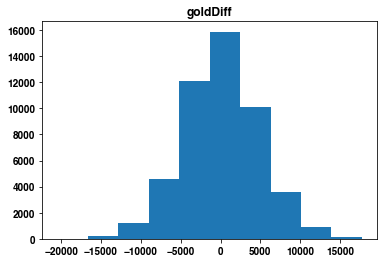

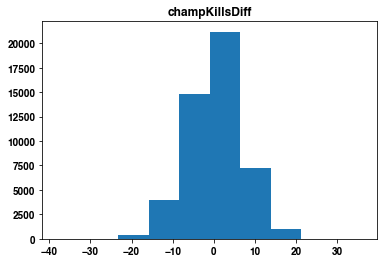

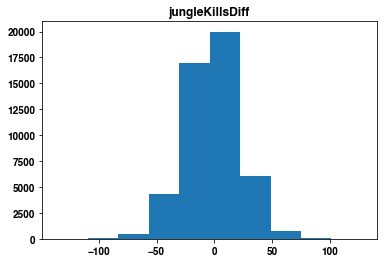

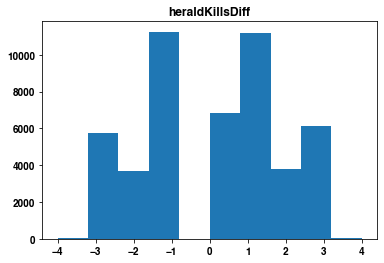

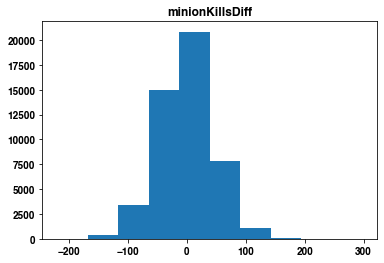

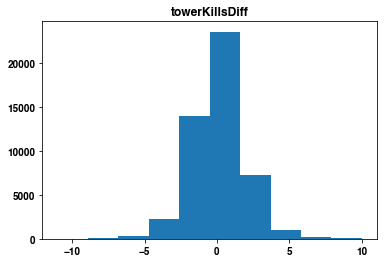

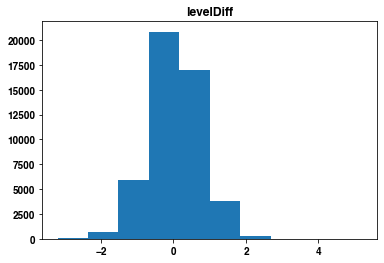

In [39]:
diff_num_col = lol_matches_diff[['goldDiff', 'champKillsDiff', 'jungleKillsDiff',
       'heraldKillsDiff', 'minionKillsDiff', 'towerKillsDiff', 'levelDiff']]
for i in diff_num_col.columns:
    plt.hist(diff_num_col[i])
    plt.title(i)
    plt.show()

We can now see that the difference in tower kills is approximately normally distributed, whereas previously it was not. 

In [122]:
X_train, X_test, y_train, y_test = train_test_split(lol_matches_diff[lol_matches_diff.columns[1:]],lol_matches_diff[lol_matches_diff.columns[0]], test_size=0.33, random_state=42)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_scaled[diff_num_col.columns]),columns =diff_num_col.columns)
X_train_scaled = X_train_scaled.set_index(X_train.index)

X_test_scaled = X_test.copy()
X_test_scaled = pd.DataFrame(scaler.transform(X_test_scaled[diff_num_col.columns]),columns =diff_num_col.columns)
X_test_scaled = X_test_scaled.set_index(X_test.index)

In [123]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.78757669 0.77864703 0.78263537 0.79291302 0.78861789]
0.7860780004084333


In [124]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.68849693 0.70102776 0.70164136 0.70823746 0.70823746]
0.7015281946024693


In [125]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.75076687 0.75057524 0.75778494 0.75824513 0.7533364 ]
0.7541417160033389


In [126]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.7756135  0.76499463 0.77312471 0.77757325 0.77496549]
0.77325431466492


In [127]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.78849693 0.77803344 0.78294217 0.79321982 0.78631692]
0.7858018562070099


In [128]:
xgb = XGBClassifier(random_state =1, eval_metric = 'logloss', use_label_encoder=False)
cv = cross_val_score(xgb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.7791411  0.76928977 0.7807946  0.78708391 0.78202178]
0.7796662328239211


In [130]:
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('dt',dt),('rf',rf),('svc',svc),('xgb',xgb)], voting = 'soft') 
cv = cross_val_score(voting_clf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.77760736 0.76867618 0.77297131 0.78631692 0.78309557]
0.7777334680975008


In [132]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import f1_score

lr.fit(X_train_scaled,y_train)
y_pred = lr.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred))

perm = PermutationImportance(lr, random_state=1).fit(X_train_scaled, y_train)
eli5.show_weights(perm, feature_names = X_train_scaled.columns.tolist())

[[6251 1656]
 [1739 6409]]
0.7906001356935793


Weight,Feature
0.1363 ± 0.0049,goldDiff
0.0143 ± 0.0025,levelDiff
0.0110 ± 0.0013,heraldKillsDiff
0.0055 ± 0.0029,champKillsDiff
0.0014 ± 0.0010,jungleKillsDiff
0.0010 ± 0.0011,towerKillsDiff
0.0002 ± 0.0013,minionKillsDiff


In [133]:
svc.fit(X_train_scaled,y_train)
y_pred = svc.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred))

perm = PermutationImportance(svc, random_state=1).fit(X_train_scaled, y_train)
eli5.show_weights(perm, feature_names = X_train_scaled.columns.tolist())

[[6229 1678]
 [1715 6433]]
0.7913155790639032


Weight,Feature
0.0568 ± 0.0034,goldDiff
0.0160 ± 0.0029,levelDiff
0.0144 ± 0.0045,champKillsDiff
0.0120 ± 0.0017,heraldKillsDiff
0.0034 ± 0.0009,jungleKillsDiff
0.0020 ± 0.0020,minionKillsDiff
0.0008 ± 0.0007,towerKillsDiff


In [44]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [45]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [79]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train_scaled,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   22.6s finished


Logistic Regression
Best Score: 0.7861086799605119
Best Parameters: {'C': 1.623776739188721, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


In [135]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 16.3min finished


KNN
Best Score: 0.7674869494267347
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


In [83]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400,450],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20],
                                  'max_features': ['auto','sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train_scaled,y_train)
clf_performance(best_clf_rf,'Random Forest') 

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 45.4min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 46.4min finished


Random Forest
Best Score: 0.7827339951082113
Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 450}


In [140]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 56.5min


KeyboardInterrupt: 

In [80]:
best_lr = best_clf_lr.best_estimator_.fit(X_train_scaled,y_train)
y_pred = best_lr.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred))

perm = PermutationImportance(best_lr, random_state=1).fit(X_train_scaled, y_train)
eli5.show_weights(perm, feature_names = X_train_scaled.columns.tolist())

[[6251 1656]
 [1739 6409]]
0.7906001356935793


Weight,Feature
0.1358 ± 0.0050,goldDiff
0.0142 ± 0.0025,levelDiff
0.0109 ± 0.0013,heraldKillsDiff
0.0055 ± 0.0029,champKillsDiff
0.0013 ± 0.0010,jungleKillsDiff
0.0009 ± 0.0011,towerKillsDiff
0.0001 ± 0.0013,minionKillsDiff


In [84]:
best_rf = best_clf_rf.best_estimator_.fit(X_train_scaled,y_train)
y_pred = best_rf.predict(X_test_scaled)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred))

perm = PermutationImportance(best_rf, random_state=1).fit(X_train_scaled, y_train)
eli5.show_weights(perm, feature_names = X_train_scaled.columns.tolist())

[[6210 1697]
 [1763 6385]]
0.7868145409735059


Weight,Feature
0.1564 ± 0.0050,goldDiff
0.0645 ± 0.0021,champKillsDiff
0.0633 ± 0.0007,levelDiff
0.0624 ± 0.0005,heraldKillsDiff
0.0540 ± 0.0010,jungleKillsDiff
0.0531 ± 0.0017,minionKillsDiff
0.0404 ± 0.0011,towerKillsDiff


In [48]:
lol_matches_diff.corr()

,blue_win,goldDiff,champKillsDiff,jungleKillsDiff,heraldKillsDiff,minionKillsDiff,towerKillsDiff,levelDiff
blue_win,1.000000,0.609821,0.579319,0.330751,0.415477,0.420706,0.479591,0.563615
goldDiff,0.609821,1.000000,0.905682,0.499748,0.543657,0.716105,0.847396,0.885344
champKillsDiff,0.579319,0.905682,1.000000,0.370627,0.493779,0.538547,0.662545,0.835097
jungleKillsDiff,0.330751,0.499748,0.370627,1.000000,0.405350,0.286902,0.394283,0.550004
heraldKillsDiff,0.415477,0.543657,0.493779,0.405350,1.000000,0.301898,0.512489,0.457682
minionKillsDiff,0.420706,0.716105,0.538547,0.286902,0.301898,1.000000,0.622471,0.664114
towerKillsDiff,0.479591,0.847396,0.662545,0.394283,0.512489,0.622471,1.000000,0.695945
levelDiff,0.563615,0.885344,0.835097,0.550004,0.457682,0.664114,0.695945,1.000000


In [49]:
#rf = RandomForestClassifier(random_state = 1)
#param_grid =  {'n_estimators': [100,500,1000], 
#                                  'bootstrap': [True,False],
#                                  'max_depth': [3,5,10,20,50,75,100,None],
#                                  'max_features': ['auto','sqrt'],
#                                  'min_samples_leaf': [1,2,4,10],
#                                  'min_samples_split': [2,5,10]}
#                                  
#clf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)
#best_clf_rf_rnd = clf_rf_rnd.fit(X_train_scaled,y_train)
#clf_performance(best_clf_rf_rnd,'Random Forest')

In [50]:
#best_rf = best_clf_rf_rnd.best_estimator_.fit(X_train_scaled,y_train)
#feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_scaled.columns)
#feat_importances.nlargest(20).plot(kind='barh')

In [51]:
#print(confusion_matrix(y_test, y_pred))
#
#perm = PermutationImportance(best_rf, random_state=1).fit(X_train_scaled, y_train)
#eli5.show_weights(perm, feature_names = X_train_scaled.columns.tolist())

In [142]:
from sklearn.compose import ColumnTransformer

pca_df = lol_matches_diff[['blue_win','goldDiff', 'champKillsDiff', 'jungleKillsDiff',
       'heraldKillsDiff', 'minionKillsDiff', 'towerKillsDiff', 'levelDiff']]

pca_df_scaled = pca_df.copy()

ct = ColumnTransformer([
        ('scaler', StandardScaler(), ['goldDiff', 'champKillsDiff', 'jungleKillsDiff',
       'heraldKillsDiff', 'minionKillsDiff', 'towerKillsDiff', 'levelDiff'])
    ], remainder='passthrough')

pca_df_scaled = pd.DataFrame(ct.fit_transform(pca_df_scaled),columns =['goldDiff', 'champKillsDiff', 'jungleKillsDiff',
       'heraldKillsDiff', 'minionKillsDiff', 'towerKillsDiff', 'levelDiff','blue_win'])
#pca_df_scaled = pd.DataFrame(scaler.transform(pca_df_scaled[diff_num_col.columns]),columns =diff_num_col.columns)
#pca_df.reset_index(drop=True, inplace=True)

pca_df_scaled.head()

,goldDiff,champKillsDiff,jungleKillsDiff,heraldKillsDiff,minionKillsDiff,towerKillsDiff,levelDiff,blue_win
0,-0.302273,-0.958180,0.457164,-0.567799,0.083713,-0.055595,-0.880814,0.0
1,-0.360307,0.112333,-2.357774,-1.119507,-0.069094,-0.055595,-0.585977,0.0
2,1.397245,0.876986,0.413857,1.639032,1.175187,2.223535,0.003697,1.0
3,-2.184577,-1.416972,-1.968013,-1.671215,-2.885097,-1.764942,-1.765326,0.0
4,1.309346,1.182847,2.232739,1.639032,0.935062,1.083970,1.477882,1.0


In [143]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

components = pca.fit_transform(pca_df_scaled)
print(pca.explained_variance_ratio_)

[0.64685187 0.11536206]


In [144]:
# create visulization df
df_vis = pd.DataFrame(data = components, columns = ['pc1', 'pc2'])
df_vis = pd.concat([df_vis, pca_df.blue_win], axis = 1)

X = df_vis[['pc1', 'pc2']]
y = df_vis['blue_win']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [145]:
# refit the pca data
best_lr.fit(X_train, y_train)

LogisticRegression(C=1.623776739188721, max_iter=2000, penalty='l1',
                   solver='liblinear')

In [153]:
# visualize function
from matplotlib.colors import ListedColormap
def DecisionBoundary(clf):
    X = df_vis[['pc1', 'pc2']]
    y = df_vis['blue_win']
    
    h = .01  # step size in the mesh

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])
    
    #Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    
    # Plot also the training points
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

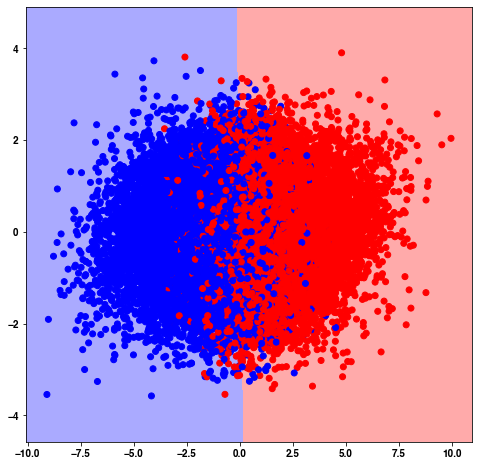

<Figure size 432x288 with 0 Axes>

In [158]:
DecisionBoundary(best_lr)
plt.savefig('images/pca_decomposision.png', dpi=300)

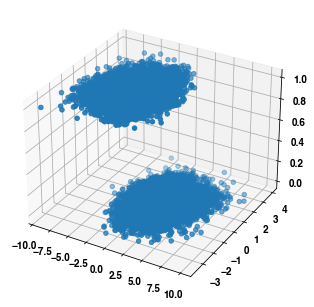

In [155]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
#ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=df_vis['pc1'],  ys=df_vis['pc2'], zs=df_vis['blue_win'])